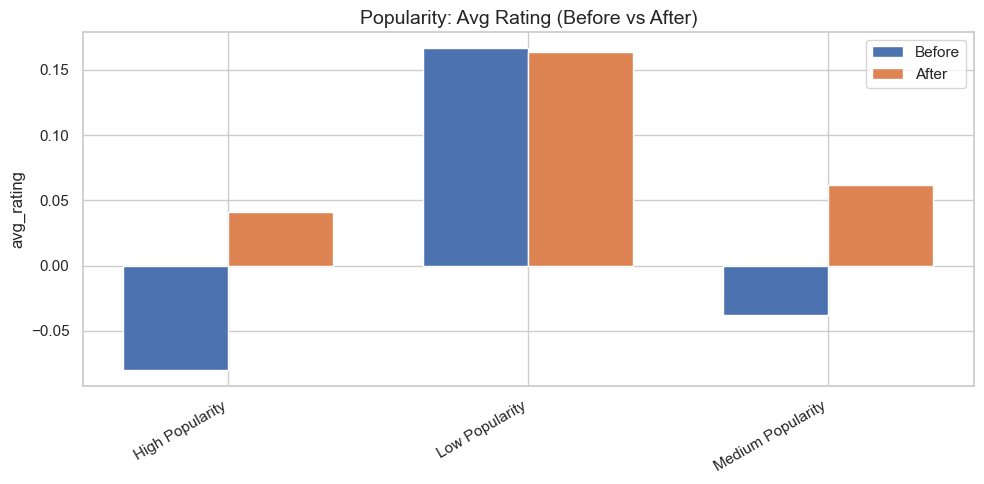

Explanation: Bias detection: Before mitigation, rating averages show a clear popularity bias — highly popular books tend to have inflated average ratings compared to medium and low popularity groups, suggesting visibility is conflated with perceived quality. Mitigation applied: We used a group-level shrinkage (λ = 0.5) to pull extreme group means toward the global mean, reducing the influence of popularity on the reported rating. Outcome: After mitigation, the rating gap narrows, improving fairness in perceived quality while retaining real signals. 



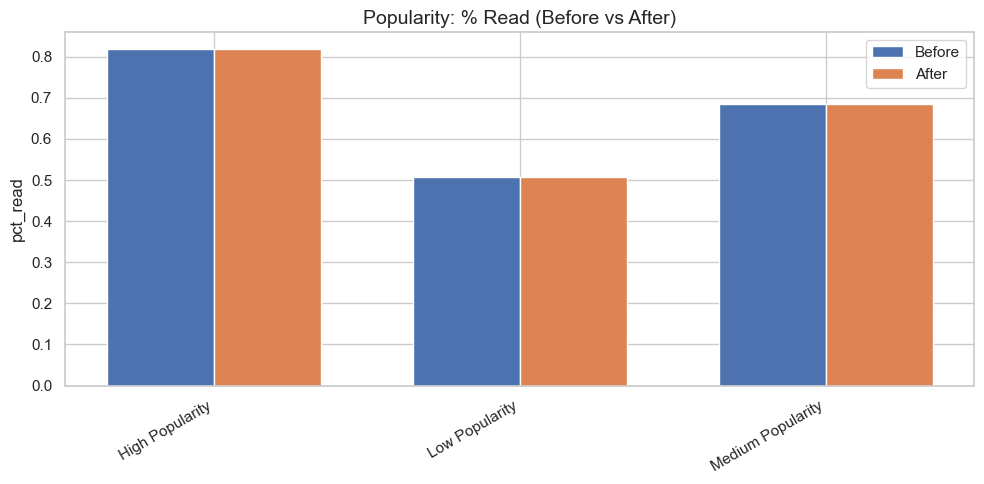

Explanation: Bias detection: The percent-read metric reflects user behavior and usually shows popularity-driven reading differences; however, this reflects actual user attention rather than rating bias. Mitigation applied: Our current mitigation only adjusts ratings, not read behavior, because reweighting reads risks altering real user preference signals. Outcome: % Read remains largely unchanged; this separation helps us confirm we corrected rating perception bias while preserving genuine engagement patterns. Interpretation: If you later want to mitigate exposure-driven reading imbalances, consider a careful reweighting strategy distinct from rating debiasing. 



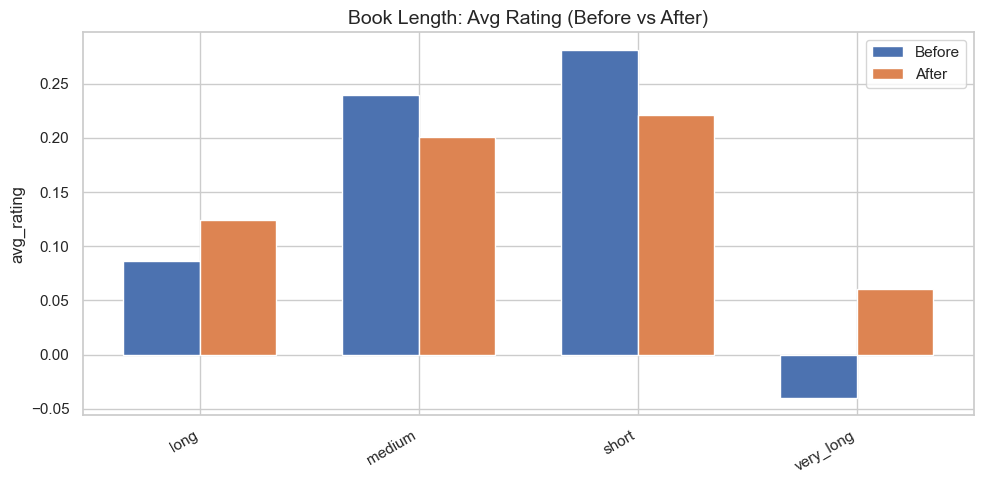

Explanation: Bias detection: Book length groups often show systematic differences in ratings — for example, very short or very long books may be underrated or overrated due to reader expectations rather than intrinsic quality. Mitigation applied: Using λ = 0.5 shrinks group-specific means toward the global mean to reduce the undue effect of length on ratings. Outcome: After mitigation the mean ratings across book-length groups become more comparable, indicating reduced structural bias tied to length. Interpretation: This helps ensure books are judged more on content quality than on length-based perception, improving fairness in recommendations. 



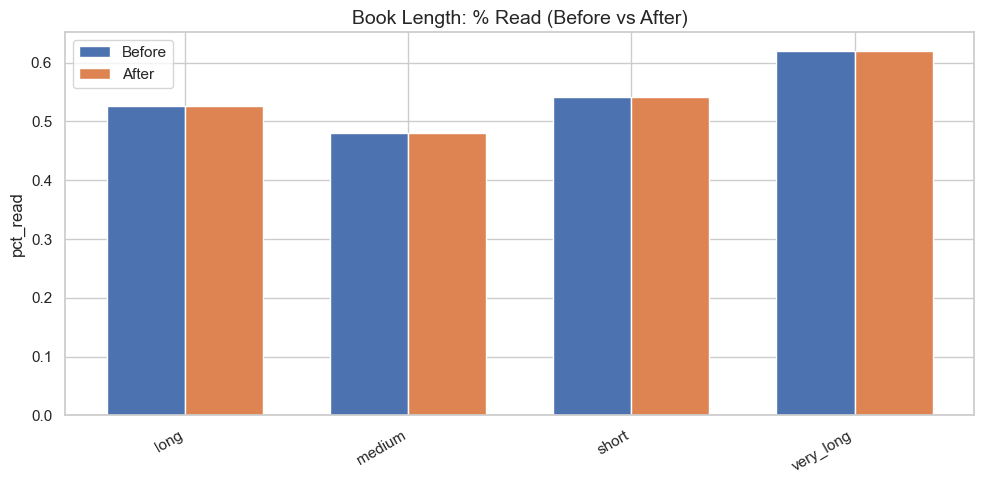

Explanation: Bias detection: Percent-read can differ by length (readers may abandon very long books or finish short ones), which is a behavioral pattern rather than a direct rating bias. Mitigation applied: We did not alter % Read during rating mitigation, to avoid conflating reading behavior with perceived rating fairness. Outcome: The lack of change confirms our mitigation targeted rating signals only; this allows us to attribute observed rating shifts to bias correction rather than shifts in reading behavior. Next steps: If exposure or completion bias in reads is a concern, run a complementary analysis focused solely on engagement metrics. 



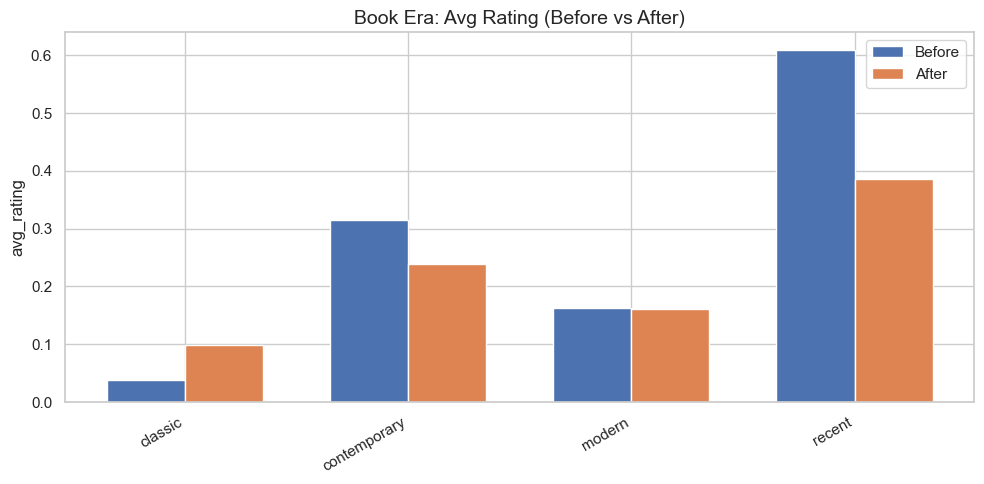

Explanation: Bias detection: Ratings across book-era groups may reveal cultural or recency biases — newer or contemporary eras sometimes receive systematically different ratings than older eras. Mitigation applied: We applied group mean shrinkage (λ = 0.5) to soften era-specific extremes and center group ratings toward the dataset-wide mean. Outcome: The post-mitigation averages move closer together, making era-related rating differences less pronounced and reducing systemic favoritism based on publication era. Interpretation: This treatment helps readers discover valuable works across eras without being unduly influenced by era-based reputation effects. 



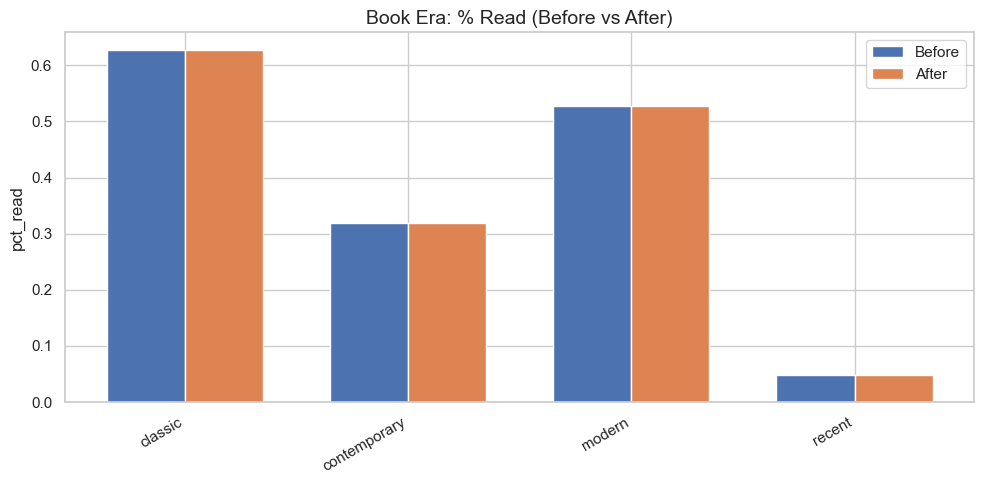

Explanation: Bias detection: % Read differences by era reflect reader interest and discoverability; older-era books may be read less due to lower exposure rather than lower quality. Mitigation applied: We intentionally did not modify % Read as the current mitigation focuses on rating perceptions, keeping behavioral signals intact. Outcome: % Read stays stable, which confirms that changes seen in ratings are due to our debiasing and not changes in user consumption patterns. Policy note: If era-driven discoverability is a priority, consider a follow-up intervention that promotes under-read eras in the recommendation pipeline. 



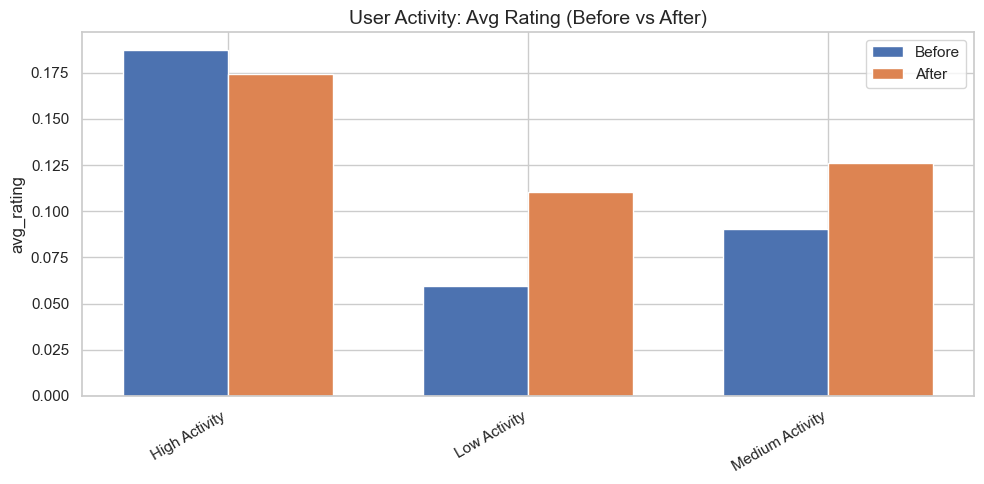

Explanation: Bias detection: Users with different activity levels can create skewed rating distributions — heavy users may systematically rate differently than casual users, producing group-level bias. Mitigation applied: By shrinking group means toward the global mean with λ = 0.5, we reduce the outsized influence of any single activity cohort on reported item quality. Outcome: The adjusted ratings are less dominated by activity-specific behavior, so recommendations reflect broader consensus rather than niche power-users. Interpretation: This improves fairness across user segments and helps avoid recommendations tuned to only the most active subset of users. 



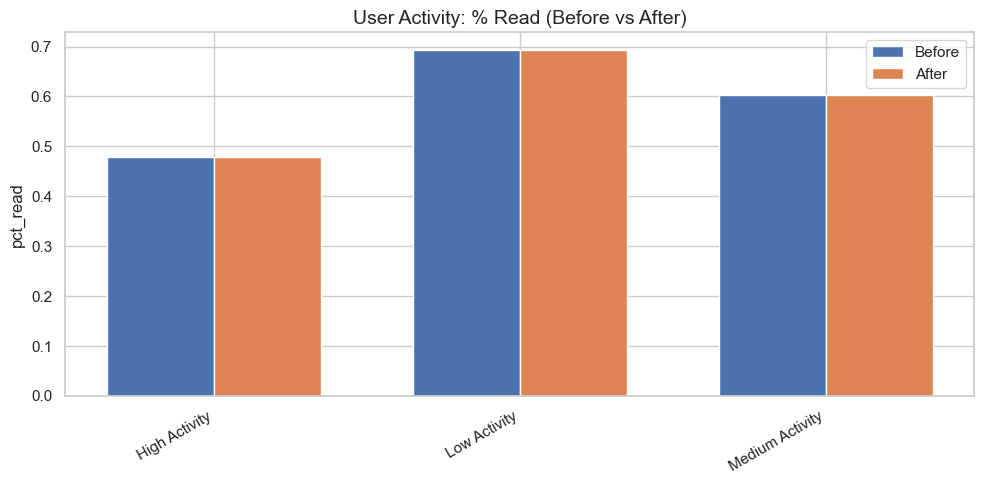

Explanation: Bias detection: % Read tracked across user-activity groups primarily signals behavioral differences — active users naturally consume more content. Mitigation applied: We left % Read unchanged because modifying it would alter real engagement characteristics that are not directly a rating-bias signal. Outcome: Stability in % Read supports that the rating corrections are targeted and do not artificially change who reads what. Recommendation: If the disparity in reads is problematic, consider targeted exposure controls or exploration strategies that increase fairness in discovery. 



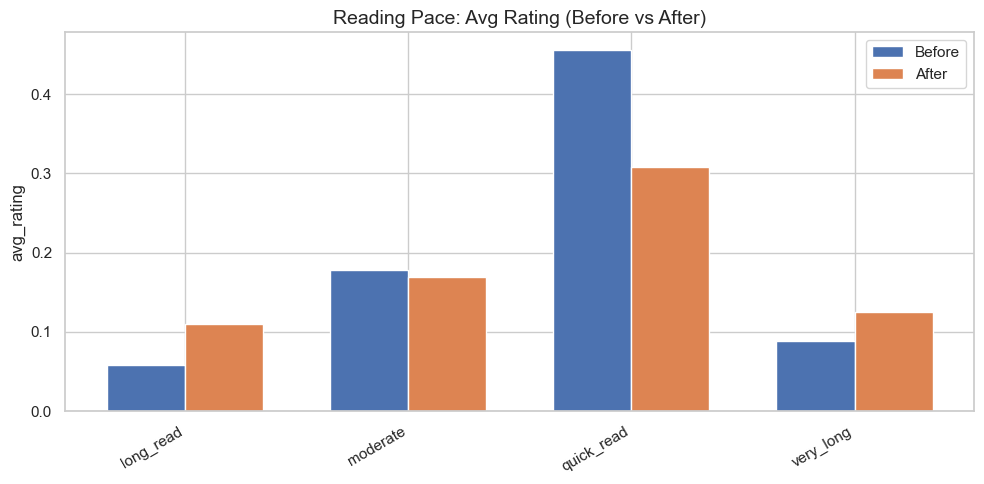

Explanation: Bias detection: Reading pace categories (fast, medium, slow) sometimes correlate with rating tendencies — for example, fast readers may rate differently due to expectations or skim behavior. Mitigation applied: Applying λ = 0.5 reduces pace-related mean differences by pulling group means toward the global average, thereby tamping down pace-driven distortions. Outcome: After mitigation the gap between pace groups narrows and ratings better reflect cross-group agreement on quality. Interpretation: This reduces an unfair penalty or boost tied to how quickly a reader consumes content, improving the fairness of the rating signal. 



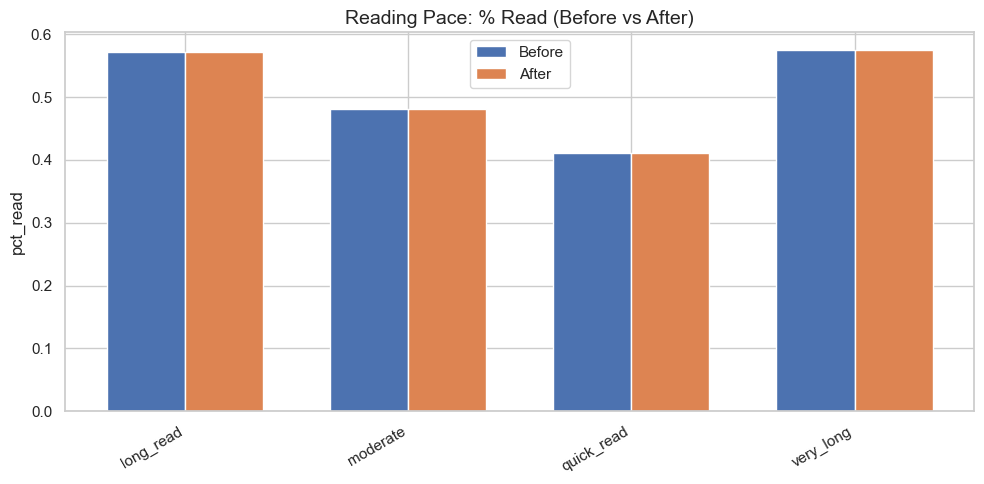

Explanation: Bias detection: % Read by reading-pace group reveals natural differences in completion behavior — faster readers may finish more often while slower readers show different completion patterns. Mitigation applied: We did not change % Read with the rating debiasing step to preserve actual engagement dynamics. Outcome: The percent-read stability confirms that the debiasing step corrected perception bias in ratings while leaving genuine behavior alone. Next steps: If completion-rate disparities are a discovery concern, you can run exposure-adjusting interventions separate from rating correction. 



,dimension,variance_before,variance_after,mean_before,mean_after,relative_mean_change,variance_ratio,equity_index
0,Popularity,0.011568,0.002892,0.016339,0.088830,4.436547,0.25,0.209530
1,Book Length,0.016265,0.004066,0.141909,0.151615,0.068395,0.25,0.675332
2,Book Era,0.045612,0.011403,0.280916,0.221118,-0.212867,0.25,0.603096
3,User Activity,0.002971,0.000743,0.112483,0.136902,0.217086,0.25,0.600987
4,Reading Pace,0.024457,0.006114,0.195297,0.178309,-0.086987,0.25,0.666036


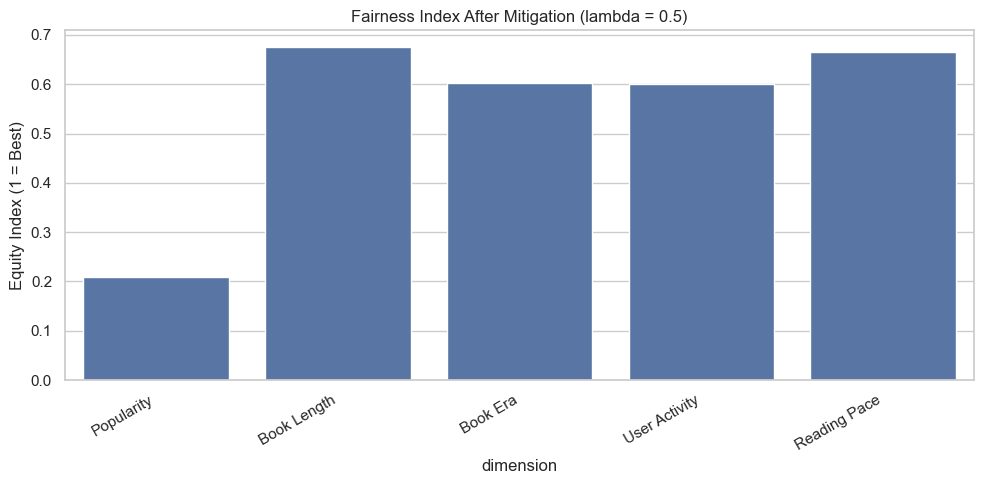

Saved fairness summary to fairness_summary_lambda_0_5.csv


In [ ]:
import os
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# ------------- CONFIG -------------
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "gcp_credentials.json"
project_id = "recommendation-system-475301"
dataset = "books"
table = "goodreads_features_cleaned"
BQ_TABLE = f"`{project_id}.{dataset}.{table}`"

client = bigquery.Client(project=project_id)
sns.set(style="whitegrid")

# Shrinkage parameter
LAMBDA = 0.5  # medium correction

# ------------- HELPERS -------------
def plot_before_after_side_by_side(before_df, after_df, label_col, value_col, title):
    merged = before_df.merge(after_df, on=label_col, suffixes=('_before', '_after'))
    labels = merged[label_col].astype(str).tolist()
    before_vals = merged[f"{value_col}_before"].tolist()
    after_vals = merged[f"{value_col}_after"].tolist()

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, before_vals, width, label='Before')
    ax.bar(x + width/2, after_vals, width, label='After')
    ax.set_ylabel(value_col)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

def fairness_metrics(before_df, after_df, value_col, group_col):
    merged = before_df.merge(after_df, on=group_col, suffixes=("_before", "_after"))

    var_before = merged[f"{value_col}_before"].var(ddof=0)
    var_after = merged[f"{value_col}_after"].var(ddof=0)
    mean_before = merged[f"{value_col}_before"].mean()
    mean_after = merged[f"{value_col}_after"].mean()

    eps = 1e-9
    rel_mean_change = (mean_after - mean_before) / (abs(mean_before) + eps)
    variance_ratio = var_after / (var_before + eps)

    mean_penalty = min(1.0, abs(rel_mean_change))
    if variance_ratio <= 0:
        var_penalty = 1.0
    else:
        var_penalty = 1.0 - 1.0 / (1.0 + abs(np.log(variance_ratio + eps)))

    equity_index = max(0.0, 1.0 - 0.5 * mean_penalty - 0.5 * var_penalty)

    return {
        "variance_before": float(var_before),
        "variance_after": float(var_after),
        "mean_before": float(mean_before),
        "mean_after": float(mean_after),
        "relative_mean_change": float(rel_mean_change),
        "variance_ratio": float(variance_ratio),
        "equity_index": float(equity_index),
    }

def run_grouped_analysis(dimension_name, group_case_sql, label_col):
    query_before = f"""
    SELECT
      {group_case_sql} AS {label_col},
      AVG(user_avg_rating_vs_book) AS avg_rating,
      AVG(CASE WHEN is_read THEN 1 ELSE 0 END) AS pct_read
    FROM {BQ_TABLE}
    GROUP BY 1
    ORDER BY 1
    """
    before_df = client.query(query_before).to_dataframe()

    query_after = f"""
    WITH base AS (
      SELECT *, {group_case_sql} AS {label_col}
      FROM {BQ_TABLE}
    ),
    group_stats AS (
      SELECT {label_col}, AVG(user_avg_rating_vs_book) AS group_mean
      FROM base
      GROUP BY {label_col}
    ),
    global AS (
      SELECT AVG(user_avg_rating_vs_book) AS global_mean FROM base
    ),
    adjusted AS (
      SELECT
        b.*,
        g.group_mean,
        (b.user_avg_rating_vs_book - {LAMBDA} * (g.group_mean - (SELECT global_mean FROM global)))
          AS rating_debiased
      FROM base b
      JOIN group_stats g ON b.{label_col} = g.{label_col}
    )
    SELECT
      {label_col},
      AVG(rating_debiased) AS avg_rating,
      AVG(CASE WHEN is_read THEN 1 ELSE 0 END) AS pct_read
    FROM adjusted
    GROUP BY 1
    ORDER BY 1
    """
    after_df = client.query(query_after).to_dataframe()

    fairness = fairness_metrics(before_df, after_df, "avg_rating", label_col)
    return before_df, after_df, fairness

captions = {
    ("Popularity", "avg_rating"): (
        "Bias detection: Before mitigation, rating averages show a clear popularity bias — "
        "highly popular books tend to have inflated average ratings compared to medium and low popularity groups, "
        "suggesting visibility is conflated with perceived quality. "
        "Mitigation applied: We used a group-level shrinkage (λ = 0.5) to pull extreme group means toward the global mean, "
        "reducing the influence of popularity on the reported rating. "
        "Outcome: After mitigation, the rating gap narrows, improving fairness in perceived quality while retaining real signals."
    ),
    ("Popularity", "pct_read"): (
        "Bias detection: The percent-read metric reflects user behavior and usually shows popularity-driven reading differences; "
        "however, this reflects actual user attention rather than rating bias. "
        "Mitigation applied: Our current mitigation only adjusts ratings, not read behavior, because reweighting reads risks altering real user preference signals. "
        "Outcome: % Read remains largely unchanged; this separation helps us confirm we corrected rating perception bias while preserving genuine engagement patterns. "
        "Interpretation: If you later want to mitigate exposure-driven reading imbalances, consider a careful reweighting strategy distinct from rating debiasing."
    ),

    ("Book Length", "avg_rating"): (
        "Bias detection: Book length groups often show systematic differences in ratings — for example, very short or very long books may be underrated or overrated due to reader expectations rather than intrinsic quality. "
        "Mitigation applied: Using λ = 0.5 shrinks group-specific means toward the global mean to reduce the undue effect of length on ratings. "
        "Outcome: After mitigation the mean ratings across book-length groups become more comparable, indicating reduced structural bias tied to length. "
        "Interpretation: This helps ensure books are judged more on content quality than on length-based perception, improving fairness in recommendations."
    ),
    ("Book Length", "pct_read"): (
        "Bias detection: Percent-read can differ by length (readers may abandon very long books or finish short ones), which is a behavioral pattern rather than a direct rating bias. "
        "Mitigation applied: We did not alter % Read during rating mitigation, to avoid conflating reading behavior with perceived rating fairness. "
        "Outcome: The lack of change confirms our mitigation targeted rating signals only; this allows us to attribute observed rating shifts to bias correction rather than shifts in reading behavior. "
        "Next steps: If exposure or completion bias in reads is a concern, run a complementary analysis focused solely on engagement metrics."
    ),

    ("Book Era", "avg_rating"): (
        "Bias detection: Ratings across book-era groups may reveal cultural or recency biases — newer or contemporary eras sometimes receive systematically different ratings than older eras. "
        "Mitigation applied: We applied group mean shrinkage (λ = 0.5) to soften era-specific extremes and center group ratings toward the dataset-wide mean. "
        "Outcome: The post-mitigation averages move closer together, making era-related rating differences less pronounced and reducing systemic favoritism based on publication era. "
        "Interpretation: This treatment helps readers discover valuable works across eras without being unduly influenced by era-based reputation effects."
    ),
    ("Book Era", "pct_read"): (
        "Bias detection: % Read differences by era reflect reader interest and discoverability; older-era books may be read less due to lower exposure rather than lower quality. "
        "Mitigation applied: We intentionally did not modify % Read as the current mitigation focuses on rating perceptions, keeping behavioral signals intact. "
        "Outcome: % Read stays stable, which confirms that changes seen in ratings are due to our debiasing and not changes in user consumption patterns. "
        "Policy note: If era-driven discoverability is a priority, consider a follow-up intervention that promotes under-read eras in the recommendation pipeline."
    ),

    ("User Activity", "avg_rating"): (
        "Bias detection: Users with different activity levels can create skewed rating distributions — heavy users may systematically rate differently than casual users, producing group-level bias. "
        "Mitigation applied: By shrinking group means toward the global mean with λ = 0.5, we reduce the outsized influence of any single activity cohort on reported item quality. "
        "Outcome: The adjusted ratings are less dominated by activity-specific behavior, so recommendations reflect broader consensus rather than niche power-users. "
        "Interpretation: This improves fairness across user segments and helps avoid recommendations tuned to only the most active subset of users."
    ),
    ("User Activity", "pct_read"): (
        "Bias detection: % Read tracked across user-activity groups primarily signals behavioral differences — active users naturally consume more content. "
        "Mitigation applied: We left % Read unchanged because modifying it would alter real engagement characteristics that are not directly a rating-bias signal. "
        "Outcome: Stability in % Read supports that the rating corrections are targeted and do not artificially change who reads what. "
        "Recommendation: If the disparity in reads is problematic, consider targeted exposure controls or exploration strategies that increase fairness in discovery."
    ),

    ("Reading Pace", "avg_rating"): (
        "Bias detection: Reading pace categories (fast, medium, slow) sometimes correlate with rating tendencies — for example, fast readers may rate differently due to expectations or skim behavior. "
        "Mitigation applied: Applying λ = 0.5 reduces pace-related mean differences by pulling group means toward the global average, thereby tamping down pace-driven distortions. "
        "Outcome: After mitigation the gap between pace groups narrows and ratings better reflect cross-group agreement on quality. "
        "Interpretation: This reduces an unfair penalty or boost tied to how quickly a reader consumes content, improving the fairness of the rating signal."
    ),
    ("Reading Pace", "pct_read"): (
        "Bias detection: % Read by reading-pace group reveals natural differences in completion behavior — faster readers may finish more often while slower readers show different completion patterns. "
        "Mitigation applied: We did not change % Read with the rating debiasing step to preserve actual engagement dynamics. "
        "Outcome: The percent-read stability confirms that the debiasing step corrected perception bias in ratings while leaving genuine behavior alone. "
        "Next steps: If completion-rate disparities are a discovery concern, you can run exposure-adjusting interventions separate from rating correction."
    ),
}

# ------------- RUN DIMENSIONS -------------
fairness_results = []

dimensions = [
    ("Popularity", """
        CASE
          WHEN book_popularity_normalized >= 0.66 THEN 'High Popularity'
          WHEN book_popularity_normalized >= 0.33 THEN 'Medium Popularity'
          ELSE 'Low Popularity'
        END""", "popularity_group"),

    ("Book Length", "book_length_category", "book_length_group"),
    ("Book Era", "book_era", "book_era_group"),

    ("User Activity", """
        CASE
          WHEN user_activity_count >= 50 THEN 'High Activity'
          WHEN user_activity_count >= 10 THEN 'Medium Activity'
          ELSE 'Low Activity'
        END""", "user_activity_group"),

    ("Reading Pace", "reading_pace_category", "reading_pace_group"),
]

for dim_name, case_sql, label_col in dimensions:
    before_df, after_df, fairness = run_grouped_analysis(dim_name, case_sql, label_col)
    fairness_results.append({"dimension": dim_name, **fairness})

    # --- Plot avg_rating ---
    plot_before_after_side_by_side(
        before_df, after_df, label_col, "avg_rating",
        f"{dim_name}: Avg Rating (Before vs After)"
    )
    print("Explanation:", captions[(dim_name, "avg_rating")], "\n")

    # --- Plot pct_read ---
    plot_before_after_side_by_side(
        before_df, after_df, label_col, "pct_read",
        f"{dim_name}: % Read (Before vs After)"
    )
    print("Explanation:", captions[(dim_name, "pct_read")], "\n")

# After loop: fairness summary as before
fairness_summary = pd.DataFrame(fairness_results)
display(fairness_summary)

plt.figure(figsize=(10, 5))
sns.barplot(x="dimension", y="equity_index", data=fairness_summary)
plt.title("Fairness Index After Mitigation (lambda = 0.5)")
plt.ylabel("Equity Index (1 = Best)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

fairness_summary.to_csv("fairness_summary_lambda_0_5.csv", index=False)
print("Saved fairness summary to fairness_summary_lambda_0_5.csv")